# Mounting Driver & packages

In [2]:
from google.colab import drive              
drive.mount('/content/gdrive/')             #mounting the google colab drive

Mounted at /content/gdrive/


In [31]:
!ls 'gdrive/MyDrive/Shangai_part_A/models/'

In [32]:
root='gdrive/MyDrive/Shangai_part_A/data/train/'   #this path is to read the input .jpg images and .mat files
model_json_path="gdrive/MyDrive/Shangai_part_A/models/VGG19/model_f1_json.json"              #path for saving and loading model object
model_h5_path="gdrive/MyDrive/Shangai_part_A/models/VGG19/model_f1_h5.h5"              #path for saving and loading model object weights
model_history_path="gdrive/MyDrive/Shangai_part_A/models/VGG19/model_f1_history.csv"  
model_metrics_path="gdrive/MyDrive/Shangai_part_A/models/VGG19/model_f1_valid_metrics.csv"  

In [5]:
#Importing  necessary packages
import os
import re
import glob
import cv2
import h5py
import json
import random
import math
import sys
import scipy
import scipy.spatial
import scipy.io as io
from scipy.ndimage.filters import gaussian_filter 
from tqdm import tqdm
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from keras.initializers import RandomNormal
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG19
#from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.losses import mean_squared_error
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.utils import Sequence

In [6]:
#reading the path of all input .jpg files 
images_paths = []
for path in [root]:
    for image_path in glob.glob(os.path.join(path, '*.jpg')):
        images_paths.append(image_path)
print(len(images_paths))   #printing total number of images available in the dataset

300


# Functions

In [7]:
#This function generates a density map for a given input array using gaussian filter
def generate_density_map(input_image):                                                  #input array with  the value 1 where ever there is a person in the image 
    density_map = np.zeros(input_image.shape, dtype=np.float32)                         #creating numpy array of shape as per the input and filled with zeros
    nonZeroCount = np.count_nonzero(input_image)                                        #Obtaining number of non zero values in the input array
    if nonZeroCount == 0:                                                               #if no person is found in the input array then returning the density map having all values as zero
        return density_map
    imageCoordinates = np.array(list(zip(np.nonzero(input_image)[1].ravel(), np.nonzero(input_image)[0].ravel())))     #creating x,y coordinates of input array
    KDTreeLeafSize = 2048                                                                                              #setting leaf value for KDTree
    KDTree = scipy.spatial.KDTree(imageCoordinates.copy(), leafsize=KDTreeLeafSize)                                    #KDTree used to compute nearest neighbours and their distances 
    distances, locations = KDTree.query(imageCoordinates, k=4)                                                         # computed distances and their locations 
    for i, point in enumerate(imageCoordinates):
        point2D = np.zeros(input_image.shape, dtype=np.float32)                                                        #creating numpy array with zeros of dimension as per input
        point2D[point[1],point[0]] = 1.                                                                                #setting the value to 1 as per the point coordinates   
        if nonZeroCount > 1:                                                                                            
            sigmaValue = (distances[i][1]+distances[i][2]+distances[i][3])*0.1                                         #If number of nonzero points in the input are greater than 1 then compute sigma value based on nearest three neighbour distances
        else:
            sigmaValue = np.average(np.array(input_image.shape))                                                       
        density_map += scipy.ndimage.filters.gaussian_filter(point2D, sigmaValue, mode='constant')                     #Adding the element wise values of every non zero point's gaussian filter value 
    return density_map

In [8]:
#This function accepts the model object as input and assigns the weights taken from  VGG19 for the top 12 convolutional layers
def assign_vgg19_weights(model):
  vggModel = VGG19(weights='imagenet', include_top=False,input_shape=(None,None,3))                                    #reading the vgg19 model object from the keras API with input shape set to (None,None,3)
  vgg19_weights=[] 
  for layer in vggModel.layers:
      if('conv' in layer.name):                                                                                        #Iterate over the vgg19 layers to read the weight of convolutional layers only
          vgg19_weights.append(layer.get_weights())
  offsetValue=0
  tempValue=0
  while(tempValue<12):
      if('conv' in model.layers[tempValue+offsetValue].name):                                                                  #For the initial covolutional layers of our model set the weights taken from VGG19
          model.layers[tempValue+offsetValue].set_weights(vgg19_weights[tempValue])
          tempValue=tempValue+1
          model.layers[tempValue+offsetValue].trainable = False
      else:
          offsetValue=offsetValue+1
  return (model)

In [9]:
#This function accepts an input image path and generates normalized numpy array
def create_input_image_to_normalized_input_array(image_path):
    image = Image.open(image_path).convert('RGB')                                        
    image_array = np.array(image)  
    image_array = image_array/255.0                                                                                       #Normalizing the numpy array
    image_array[:,:,0]=(image_array[:,:,0]-0.485)/0.229
    image_array[:,:,1]=(image_array[:,:,1]-0.456)/0.224
    image_array[:,:,2]=(image_array[:,:,2]-0.406)/0.225
    return image_array

In [10]:
#This function accepts an ouput h5 file path and generates resized numpy array of size 1/8 of the input file
def create_resized_ouput_h5file(h5_path):
    h5_file = h5py.File(h5_path,'r')
    output_array = np.asarray(h5_file['density'])
    h5_resized = cv2.resize(output_array,(int(output_array.shape[1]/8),int(output_array.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64                         #resizing the input h5 file to a file of size 1/8th of original
    h5_resized_array = np.expand_dims(h5_resized,axis  = 2)
    return h5_resized_array

In [11]:
class DatasetSequence(Sequence):
    def __init__(self, input_image_paths, input_density_paths):
        self.input_image_paths = input_image_paths
        self.input_density_paths = input_density_paths
        
    def __len__(self):
        return len(self.input_image_paths)

    def __getitem__(self, idx):
        try:
            image_path = self.input_image_paths[idx]
            density_path = self.input_density_paths[idx]
            image_array=create_input_image_to_normalized_input_array(image_path)
            density_array = create_resized_ouput_h5file(density_path)
            image_batch=[]
            image_batch.append(image_array)
            image_output=np.array(image_batch)
            density_batch=[]
            density_batch.append(density_array)
            density_output=np.array(density_batch)
            return image_output, density_output
        except:
            pass

In [12]:
#Function for computing euclidean loss
def compute_euclidean_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))                                                                                    

In [13]:
def save_model(model):
    model.save_weights(model_h5_path)
    model_json = model.to_json()
    with open(model_json_path, "w") as json_file:
        json_file.write(model_json)

In [14]:
def load_model():
  with open(model_json_path, 'r') as json_file:
    loaded_model_json = json_file.read()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights(model_h5_path)
  return loaded_model

In [15]:
#This function accepts input image path and get the image file name without the .jpg extension
def name_of_image(image_path):
  input_path=re.sub(root,'',image_path)
  input_path=re.sub('.jpg','',input_path).replace('IMG_','')
  return int(input_path)

In [16]:
#This function accepts input image path and get the image file name without the .jpg extension
def name_of_validation_image(image_path):
  image_path=image_path.replace('test','train')
  input_path=re.sub(root,'',image_path)
  input_path=re.sub('.jpg','',input_path).replace('IMG_','')
  return int(input_path)

In [17]:
def save_history(history_data):
  history_data = pd.DataFrame(model.history.history) 
  with open(model_history_path, mode='w') as f:
      history_data.to_csv(f,index=False)

In [18]:
def save_metrics(metric_data):
  with open(model_metrics_path, mode='w') as f:
      metric_data.to_csv(f,index=False)

In [19]:
def return_metrics_data(valid_image_paths):
  Validation_data=[]
  MAE=0
  MSE=0
  for image in valid_data_paths:
    image_input = []
    h5_output = [] 
    image_input_array = create_input_image_to_normalized_input_array(image)                                                                 #reading input image and creating normalized numpy array
    h5_output_array = create_resized_ouput_h5file(image.replace('.jpg','.h5').replace('data','modified_data') )                             #reading the ouput h5 file with shape resizing  
    image_input.append(image_input_array)
    h5_output.append(h5_output_array)                                                                                                     
    input_array = np.array(image_input)
    output_array = np.array(h5_output)
    predicted=int(np.sum(model.predict(input_array))+1)
    h5_output_file = h5py.File(image.replace('.jpg','.h5').replace('data','modified_data'),'r')
    target_density = np.asarray(h5_output_file['density'])
    actual=int(np.sum(target_density)) + 1
    MAE = MAE + abs(actual - predicted)
    MSE = MSE + (actual - predicted) * (actual - predicted)
    Validation_data.append([name_of_validation_image(image),(actual - predicted)*(actual - predicted),abs(actual - predicted),predicted,actual])
  Validation_data=pd.DataFrame(Validation_data,columns=['IMAGE_NAME','SQUARED_ERROR','ABSOLUTE_ERROR','PREDICTED_COUNT','ACTUAL_COUNT'])
  return Validation_data      

# Density map generation

In [ ]:
'''
#This block of code loops through the list of image paths and generates the density map for each image
for image_path in tqdm(images_paths):
    input_mat = io.loadmat(image_path.replace('.jpg','.mat').replace('IMG_','GT_IMG_'))                                                                                #load the .mat file having the annotations
    input_image = plt.imread(image_path)                                                                                                         #load the input image file
    input_imageArray = np.zeros((input_image.shape[0],input_image.shape[1]))                                                                     #create a numpy array of input image shape and with the values filled as zeros
    input_matPoints = input_mat["image_info"][0][0][0][0][0]
    for index in range(0,len(input_matPoints)):
        if int(input_matPoints[index][1])<input_image.shape[0] and int(input_matPoints[index][0])<input_image.shape[1]:                           #points where coordinates are within the given input image dimensions, set the value to 1
           input_imageArray[int(input_matPoints[index][1]),int(input_matPoints[index][0])]=1
    input_density_map_array = generate_density_map(input_imageArray)
    h5file_path = image_path.replace('.jpg','.h5').replace('data','modified_data')
    with h5py.File(h5file_path, 'w') as h5file:
            h5file['density'] = input_density_map_array
'''

100%|██████████| 182/182 [52:50<00:00, 17.42s/it]


#Model compile

In [20]:
kernelShape=(3, 3)
weights_initialization=RandomNormal(stddev=0.05)

In [21]:
model = Sequential() 
model.add(Conv2D(64,  kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization, input_shape = (None, None, 3)))
model.add(Conv2D(64,  kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(128, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(128, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(256, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(256, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(256, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(256, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(MaxPooling2D(strides=2))            
model.add(Conv2D(512, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(512, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(512, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(512, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization))
model.add(Conv2D(512, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization, dilation_rate = 2))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization, dilation_rate = 2))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization, dilation_rate = 2))
model.add(BatchNormalization())
model.add(Conv2D(64,  kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization, dilation_rate = 2))
model.add(BatchNormalization())
model.add(Conv2D(32,  kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization, dilation_rate = 2))
model.add(BatchNormalization())
model.add(Conv2D(16,  kernel_size = kernelShape, activation = 'relu', padding='same', kernel_initializer = weights_initialization, dilation_rate = 2))
model.add(BatchNormalization())
model.add(Conv2D(1,   kernel_size = (1, 1),      activation='relu',   padding='same', kernel_initializer = weights_initialization, dilation_rate = 1))
#optimizer = SGD(lr = 0.0001, momentum = 0.9,clipvalue=0.7)
#model.compile(optimizer=sgd, metrics=['mse'],loss=keras.losses.MeanSquaredError())
optimizer = Adam(learning_rate=0.00001)
model = assign_vgg19_weights(model)
model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])

80150528/80134624 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                    

# Model Training

In [23]:
#reading the path of all input .jpg files 
train_data_paths = []
for path in [root]:
    for image_path in glob.glob(os.path.join(path, '*.jpg')):
        train_data_paths.append(image_path)
print(len(train_data_paths))   #printing total number of images available in the dataset

300


In [ ]:
#train_data_paths=train_data_paths[:50]

In [24]:
#reading the path of all input .jpg files 
valid_data_paths = []
for path in [root.replace('train','test')]:
    for image_path in glob.glob(os.path.join(path, '*.jpg')):
        valid_data_paths.append(image_path)
print(len(valid_data_paths))   #printing total number of images available in the dataset

182


In [25]:
train_density_paths=[i.replace('.jpg','.h5').replace('data','modified_data') for i in train_data_paths ]
len(train_density_paths)

300

In [26]:
generated_train_data = DatasetSequence(train_data_paths, train_density_paths)

In [27]:
model.fit(generated_train_data,epochs=10,steps_per_epoch=300,shuffle=True, verbose=1)

Epoch 1/10
300/300 [==============================] - 666s 2s/step - loss: 0.0507 - mae: 0.0933
Epoch 2/10
300/300 [==============================] - 65s 217ms/step - loss: 0.0435 - mae: 0.0823
Epoch 3/10
300/300 [==============================] - 65s 217ms/step - loss: 0.0413 - mae: 0.0760
Epoch 4/10
300/300 [==============================] - 65s 217ms/step - loss: 0.0397 - mae: 0.0720
Epoch 5/10
300/300 [==============================] - 65s 217ms/step - loss: 0.0386 - mae: 0.0692
Epoch 6/10
300/300 [==============================] - 65s 217ms/step - loss: 0.0377 - mae: 0.0677
Epoch 7/10
300/300 [==============================] - 65s 218ms/step - loss: 0.0370 - mae: 0.0659
Epoch 8/10
300/300 [==============================] - 65s 218ms/step - loss: 0.0362 - mae: 0.0645
Epoch 9/10
300/300 [==============================] - 65s 216ms/step - loss: 0.0356 - mae: 0.0633
Epoch 10/10
300/300 [==============================] - 65s 217ms/step - loss: 0.0351 - mae: 0.0624


In [28]:
model.history.history                  

{'loss': [0.05071263760328293,
  0.043535880744457245,
  0.0412914864718914,
  0.039740752428770065,
  0.038637880235910416,
  0.03771701827645302,
  0.037016235291957855,
  0.0361970029771328,
  0.03560221940279007,
  0.03511563315987587],
 'mae': [0.09328258782625198,
  0.08229400217533112,
  0.07601569592952728,
  0.0719706118106842,
  0.06915810704231262,
  0.06765493750572205,
  0.06593098491430283,
  0.06454825401306152,
  0.06328318268060684,
  0.06242015212774277]}

In [33]:
save_history(model.history.history)

# Model metrics on validation data

In [34]:
valid_metrics=return_metrics_data(valid_data_paths)

In [35]:
valid_metrics.head(10)

,IMAGE_NAME,SQUARED_ERROR,ABSOLUTE_ERROR,PREDICTED_COUNT,ACTUAL_COUNT
0,99,19044,138,103,241
1,98,6241,79,68,147
2,95,4900,70,116,186
3,91,4624,68,28,96
4,94,1764,42,22,64
5,9,46225,215,153,368
6,97,55696,236,705,469
7,90,25,5,2240,2245
8,96,7744,88,329,241
9,88,1156,34,51,85


In [36]:
print("RMSE error :",np.sqrt(np.mean(valid_metrics['SQUARED_ERROR'])))

RMSE error : 182.93427931760235


In [37]:
print("MAE error :",np.mean(valid_metrics['ABSOLUTE_ERROR']))

MAE error : 124.86263736263736


In [ ]:
save_metrics(valid_metrics)

# Save model

In [38]:
save_model(model)

# Display Sample Predictions

In [39]:
loaded_model=load_model()

In [40]:
image_path=valid_data_paths[100]
image_path

'gdrive/MyDrive/Shangai_part_A/data/test/IMG_18.jpg'

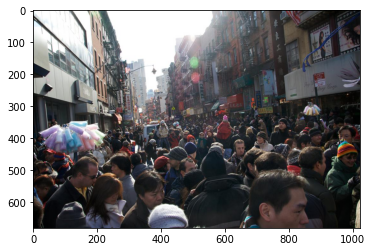

In [41]:
#Actual Image
img = Image.open(image_path).convert('RGB')
plt.imshow(img)

Actual count:  226


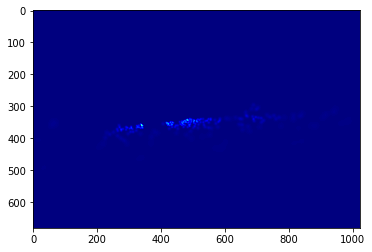

In [42]:
#Ground truth density map
gt_file = h5py.File(image_path.replace('.jpg','.h5').replace('data','modified_data'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
print("Actual count: ",int(np.sum(groundtruth)+1))

Predicted count:  121


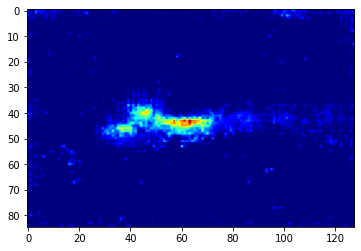

In [43]:
#Predicted Density map
image_input = []
image_input_array = create_input_image_to_normalized_input_array(image_path)  
image_input.append(image_input_array)
input_array = np.array(image_input)
predicted_density_map=loaded_model.predict(input_array)[0]
plt.imshow(np.squeeze(predicted_density_map, axis=(2,)),cmap=CM.jet)
print("Predicted count: ",int(np.sum(predicted_density_map)+1))